<a href="https://colab.research.google.com/github/aldodec/Neural_Networks/blob/master/Jena_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Files

In [0]:
import os

In [0]:
data_dir = '/content/drive/My Drive/jena_climate'
fname = os.path.join(data_dir,'jena_climate_2009_2016.csv')

In [3]:
os.listdir(data_dir)

['jena_climate_2009_2016.csv',
 'jena_climate_2009_2016.csv.zip',
 'cp.ckpt.index',
 'cp.ckpt.data-00001-of-00002',
 'cp.ckpt.data-00000-of-00002',
 'checkpoint']

In [0]:
f = open(fname)
data = f.read()
f.close()

In [0]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [6]:
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [7]:
print(len(lines))

420551


In [0]:
## We now convert the data into a numpy array:

In [0]:
import numpy as np

In [0]:
no_instances = len(lines)
no_features = len(header) - 1

float_data = np.zeros((no_instances,no_features))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values

## Basic EDA and Data Processing

In [0]:
## EDA

In [0]:
import matplotlib.pyplot as plt

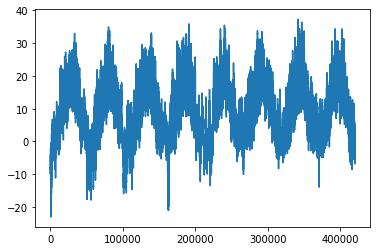

In [11]:
temp = float_data[:,1] ## This is the temperature
plt.plot(range(len(temp)),temp) # We plot the whole data

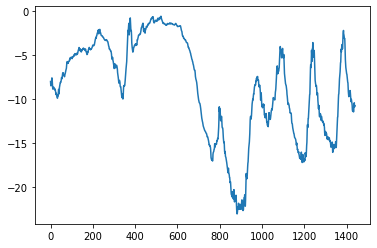

In [12]:
plt.plot(range(1440),temp[:1440]) # We plot the first 10 days of data:

In [0]:
## In both cases we notice periodicity.
## Is this series predictable at a daily scale? 

In [0]:
## Problem Statement
# Given data going back as 'lookback' timesteps (one timestep is 10 mins.),
# and sampled every 'steps' timesteps,
# Can you predict the temperature in 'delay' timesteps?

In [0]:
## We'll use the following parameters:
# - lookback = 720 - Observations will go back 5 days.
# - steps = 6 - Observations will be sampled at one data point per hour.
# - delay = 144 - Targets will be 24 hours in the future. 

In [0]:
## We have to standarize data.
## Also, we'll se the first 200,000 timesteps as training data.

In [0]:
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

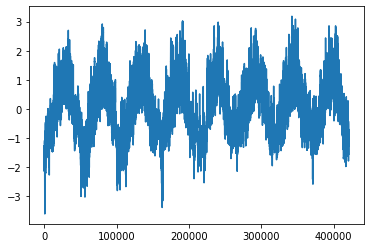

In [14]:
temp_std = float_data[:,1] ## This is the temperature, but now standardized
plt.plot(range(len(temp_std)),temp_std) # We plot the whole data

In [0]:
#######################################################

## Data Generators

In [0]:
## DATA GENERATORS

In [0]:
def generator(data, lookback, delay, min_index, max_index,
             shuffle=False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i,min(i+batch_size,max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback//step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j]-lookback,rows[j],step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [0]:
val_steps = (300000 - 200001 - lookback)// batch_size # How many steps o draw from val_gen in order to see entire val. set.
test_steps = (len(float_data) - 300001 - lookback)// batch_size # idem. for test set.

## Naive Predictor

In [0]:
## Naive Baseline prediction:
# Temperature in 24 hrs. will be equal to temperature today.

In [0]:
def evaluate_naive_method():
    batch_mae = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_mae.append(mae)
    print(np.mean(batch_mae))

In [24]:
evaluate_naive_method() ## This is the baseline error

0.2897359729905486


In [0]:
#####################################################

## Basic ML Approach

In [0]:
## Basic ML approach

In [25]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [0]:
# Building the model

model = Sequential()
model.add(layers.Flatten(input_shape = (lookback//step,float_data.shape[-1])))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(),loss = 'mae')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3360)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                107552    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 16s 32ms/step - loss: 1.3986 - val_loss: 0.7341
Epoch 2/20
500/500 [==============================] - 15s 30ms/step - loss: 0.4509 - val_loss: 0.3229
Epoch 3/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2901 - val_loss: 0.3380
Epoch 4/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2651 - val_loss: 0.3245
Epoch 5/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2541 - val_loss: 0.3488
Epoch 6/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2460 - val_loss: 0.3293
Epoch 7/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2386 - val_loss: 0.3315
Epoch 8/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2328 - val_loss: 0.3182
Epoch 9/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2289 - val_loss: 0.3381
Epoch 10/20
500/500 [==============================] - 15s 30ms/step - loss: 0.225

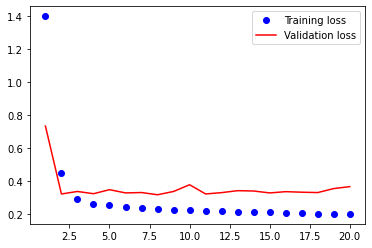

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'r',label = 'Validation loss')
#plt.ylim(0.17,0.45)
plt.legend()
plt.show()

In [0]:
############################################################

## Recurrent Neural Network Approach

In [0]:
## RNN

In [0]:
# The first approach flattened the time series
# which removed the notion of time. 
# We use a GRU layer. 

In [0]:
model = Sequential()
model.add(layers.GRU(32,input_shape = (None,float_data.shape[-1]) ))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')

In [0]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs = 20,
                             validation_data = val_gen,
                             validation_steps= val_steps)

Epoch 1/20
500/500 [==============================] - 15s 31ms/step - loss: 0.1994 - val_loss: 0.3414
Epoch 2/20
500/500 [==============================] - 15s 30ms/step - loss: 0.1983 - val_loss: 0.3474
Epoch 3/20
500/500 [==============================] - 15s 30ms/step - loss: 0.1969 - val_loss: 0.3414
Epoch 4/20
500/500 [==============================] - 15s 30ms/step - loss: 0.1951 - val_loss: 0.3411
Epoch 5/20
500/500 [==============================] - 15s 30ms/step - loss: 0.1939 - val_loss: 0.3890
Epoch 6/20
500/500 [==============================] - 15s 30ms/step - loss: 0.1929 - val_loss: 0.3436
Epoch 7/20
500/500 [==============================] - 15s 31ms/step - loss: 0.1909 - val_loss: 0.3408
Epoch 8/20
500/500 [==============================] - 15s 30ms/step - loss: 0.1909 - val_loss: 0.3492
Epoch 9/20
500/500 [==============================] - 15s 30ms/step - loss: 0.1901 - val_loss: 0.3341
Epoch 10/20
500/500 [==============================] - 15s 30ms/step - loss: 0.189

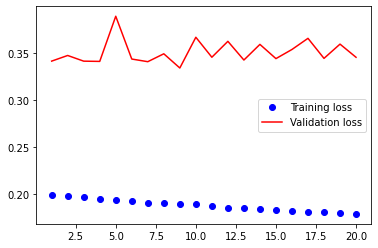

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'r',label = 'Validation loss')
#plt.ylim(0.17,0.45)
plt.legend()
plt.show()  

In [0]:
## note: validation does this weird thing with this version.

### Version Tests

In [0]:
##### Aside. Fresh start?

In [23]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [24]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [0]:
from tensorflow import keras

In [26]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [27]:
model = Sequential()
model.add(layers.GRU(32,input_shape = (None,float_data.shape[-1]) ))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [29]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs = 20,
                             validation_data = val_gen,
                             validation_steps= val_steps)

Epoch 1/20
500/500 [==============================] - 176s 352ms/step - loss: 0.2067 - val_loss: 0.2169
Epoch 2/20
500/500 [==============================] - 175s 350ms/step - loss: 0.2037 - val_loss: 0.2059
Epoch 3/20
500/500 [==============================] - 176s 351ms/step - loss: 0.2007 - val_loss: 0.2634
Epoch 4/20
500/500 [==============================] - 176s 353ms/step - loss: 0.1991 - val_loss: 0.2808
Epoch 5/20
500/500 [==============================] - 175s 350ms/step - loss: 0.1952 - val_loss: 0.2676
Epoch 6/20
500/500 [==============================] - 171s 342ms/step - loss: 0.1912 - val_loss: 0.3063
Epoch 7/20
500/500 [==============================] - 173s 347ms/step - loss: 0.1907 - val_loss: 0.2251
Epoch 8/20
500/500 [==============================] - 172s 344ms/step - loss: 0.1882 - val_loss: 0.2671
Epoch 9/20
500/500 [==============================] - 176s 351ms/step - loss: 0.1869 - val_loss: 0.3101
Epoch 10/20
500/500 [==============================] - 172s 344m

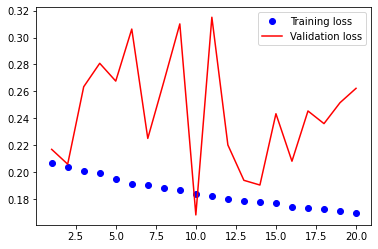

In [30]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'r',label = 'Validation loss')
#plt.ylim(0.17,0.45)
plt.legend()
plt.show()  

In [0]:
## It is too noisy

In [0]:
####################################################

## Recurrent Neural Network Approach: Adding Dropout

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [0]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape = (None,float_data.shape[-1]) ))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')

In [0]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs = 40,
                             validation_data = val_gen,
                             validation_steps= val_steps)

Epoch 1/40
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
500/500 [==============================] - 126s 252ms/step - loss: 0.3486 - val_loss: 0.2740
Epoch 2/40
500/500 [==============================] - 126s 252ms/step - loss: 0.3151 - val_loss: 0.2717
Epoch 3/40
500/500 [==============================] - 125s 250ms/step - loss: 0.3079 - val_loss: 0.2708
Epoch 4/40
500/500 [==============================] - 126s 251ms/step - loss: 0.3054 - val_loss: 0.2704
Epoch 5/40
500/500 [==============================] - 129s 257ms/step - loss: 0.3015 - val_loss: 0.2705
Epoch 6/40
500/500 [==============================] - 125s 251ms/step - loss: 0.2992 - val_loss: 0.2716
Epoch 7/40
500/500 [==============================] - 125s 251ms/step - loss: 0.2961 - val_loss: 0.2693
Epoch 8/40
500/500 [==============================] - 125s 249ms/step - loss: 0.2955 - val_loss: 0.2672
Epoch 9/40
500/500 [==============================] - 125s 249ms/step - lo

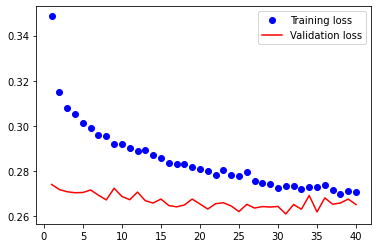

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'r',label = 'Validation loss')
#plt.ylim(0.17,0.45)
plt.legend()
plt.show()

In [0]:
########################################

## Recurrent Neural Network Approach: Adding Layers

In [0]:
## We stack recurrent layers

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import callbacks

In [27]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1, ## I'll use the same values as Chollet
                     recurrent_dropout=0.5,
                     return_sequences = True,
                     input_shape = (None,float_data.shape[-1])))
model.add(layers.GRU(64,activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5))
model.add(layers.Dense(1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 32)          4512      
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 23,201
Trainable params: 23,201
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer=RMSprop(), loss='mae')

In [0]:
## I add a checkpoint:

In [0]:
checkpoint_path = '/content/drive/My Drive/jena_climate/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [32]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps,
                              callbacks=[cp_callback])

Epoch 1/40
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
769/500 [==============================================] - 145s 188ms/step - loss: 0.2433

Epoch 00001: saving model to /content/drive/My Drive/jena_climate/cp.ckpt
500/500 [==============================] - 566s 1s/step - loss: 0.3340 - val_loss: 0.2815
Epoch 2/40
769/500 [==============================================] - 144s 187ms/step - loss: 0.2230

Epoch 00002: saving model to /content/drive/My Drive/jena_climate/cp.ckpt
500/500 [==============================] - 562s 1s/step - loss: 0.3117 - val_loss: 0.2749
Epoch 3/40
769/500 [==============================================] - 144s 188ms/step - loss: 0.2907

Epoch 00003: saving model to /content/drive/My Drive/jena_climate/cp.ckpt
500/500 [==============================] - 559s 1s/step - loss: 0.3071 - val_loss: 0.2722
Epoch 4/40
769/500 [==============================================] - 142s 185ms/step - loss: 0.2773

Epoch 

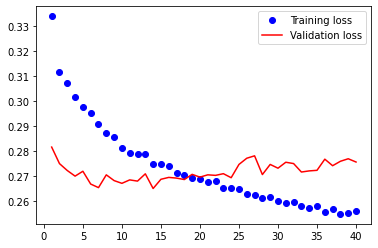

In [33]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'r',label = 'Validation loss')
#plt.ylim(0.17,0.45)
plt.legend()
plt.show()

## Bidirectional RNN

In [0]:
def generator(data, lookback, delay, min_index, max_index,
             shuffle=False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i,min(i+batch_size,max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback//step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j]-lookback,rows[j],step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1,:], targets

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [0]:
val_steps = (300000 - 200001 - lookback)// batch_size # How many steps o draw from val_gen in order to see entire val. set.
test_steps = (len(float_data) - 300001 - lookback)// batch_size # idem. for test set.

In [18]:
%tensorflow_version 1.x

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

TensorFlow 1.x selected.


In [19]:
model = Sequential()
model.add(layers.GRU(32,input_shape = (None,float_data.shape[-1]) ))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs = 20,
                             validation_data = val_gen,
                             validation_steps= val_steps)

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
500/500 [==============================] - 246s 492ms/step - loss: 0.4769 - val_loss: 0.4877
Epoch 2/20
500/500 [==============================] - 237s 474ms/step - loss: 0.4467 - val_loss: 0.4777
Epoch 3/20
500/500 [==============================] - 240s 479ms/step - loss: 0.3903 - val_loss: 0.4685
Epoch 4/20
500/500 [==============================] - 237s 473ms/step - loss: 0.3509 - val_loss: 0.4622
Epoch 5/20
500/500 [==============================] - 238s 477ms/step - loss: 0.3321 - val_loss: 0.4613
Epoch 6/20
500/500 [==============================] - 234s 469ms/step - loss: 0.3181 - val_loss: 0.4736
Epoch 7/20
500/500 [==============================] - 235s 471ms/step - loss: 0.3052 - val_loss: 0.4732
Epoch 8/20
500/500 [==============================] - 237s 474ms/step - loss: 0.2962 - val_loss: 0.4564
Epoch 9/20
500/500 [==============================] - 237s 474ms/step - lo

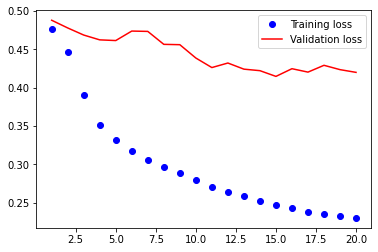

In [21]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'r',label = 'Validation loss')
#plt.ylim(0.17,0.45)
plt.legend()
plt.show()  